## Example - Standard Workflow
**An Introduction to the deconomix Python package**

To make you familiar with our package, we want to introduce the basic methods by demonstrating them on an example.
First, install the package to your current Python environment following the instructions in ```Readme.md```.

We can verify the installation by importing `deconomix` into our notebook. Calling `help()` for different functions displays their respective documentation. There is also a web-based, searchable documentation available [here](https://medbioinf.pages.gwdg.de/MedicalDataScience/DeconomiX/) . We also need functions from `scipy` and `matplotlib` to validate our results and want to use dataframes from `pandas` to work with labelled data.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import deconomix

Now we want to import an example dataset, which features single cell gene expression values for different cells from melanoma related samples. (Tirosh et al., doi:10.1126/science.aad0501). We provide `load_example()` function, which automatically downloads the data from NCBI and preprocesses it, so that we have values in the transcripts-per-million (tpm) unit, already splitted into a train and test set. Attention: You need to have sufficient amount of RAM for this. We also restricted the gene space to the 1000 most variable genes between the different cell types. The different datasets contain data from different tumors:

In [2]:
test, train = deconomix.utils.load_example()

Raw data already downloaded
Importing Data to Python ...
Using cached, preprocessed data
Done


To construct a deconvolution problem, we will convolute the single cell profiles into artificial bulk mixtures, which are linear combinations of different examples for different cell types, featured in `Y_mat`. It is important to have multiple example profiles per celltype. Their respective compositions out of the different celltypes are saved in `C_mat`. Later we also need a reference matrix `X_ref`, which provides reference gene expression profiles for each celltype. One can use a seperately derived matrix for that, our `simulate_data` method constructs one by averaging over all examples per celltype. Furthermore it generates artificial mixtures from the single cell profile examples, proportional to their frequency in the training data. Please take a look at the dimensions of the data (1001 genes, 7 celltypes, 1000 artificial bulk profiles):

In [3]:
X_ref, Y_mat, C_mat = deconomix.utils.simulate_data(train, n_mixtures = 1000, n_cells_in_mix = 100)
display(X_ref)
display(Y_mat)
display(C_mat)

Celltypes,B,CAF,Endo,Macro,NK,T
Genes,,,,,,
HLA-DRA,9.403316,1.341823,2.739208,10.307601,1.437842,2.550748
TYROBP,0.192704,0.000000,0.048972,8.554723,4.998632,0.186063
NKG7,0.111884,0.057472,0.000000,0.640962,8.609620,4.557936
IGFBP7,0.082544,6.656996,8.514133,0.465003,0.855392,0.092613
FCER1G,0.080774,0.058588,0.078344,8.163947,4.712464,0.130426
...,...,...,...,...,...,...
IMPDH2,1.612267,3.090924,1.419141,1.451488,0.385728,1.039015
SAR1A,0.968891,3.849346,2.746943,2.200724,3.310328,1.659052
RBMS3,0.022851,2.432064,1.234690,0.112185,0.000000,0.117973


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Genes,,,,,,,,,,,,,,,,,,,,,
HLA-DRA,3.422725,3.430437,4.487449,4.587838,3.739413,3.681875,4.078229,4.156290,4.147995,5.075599,...,4.799864,4.322020,4.537697,4.377272,4.165234,4.391478,3.689701,4.174107,3.673638,4.250688
TYROBP,0.669711,0.587173,0.493683,0.646633,0.747464,0.387052,0.663646,0.582618,0.858705,0.448125,...,0.639342,0.672713,0.843742,0.936117,0.304771,0.443505,0.505793,0.484655,0.794564,1.121020
NKG7,2.638554,3.573452,2.995858,3.794813,3.322530,3.515420,3.478985,2.799614,2.853503,3.283068,...,3.262676,3.152940,2.937719,2.887726,3.187948,3.618640,3.659860,2.627819,3.850366,3.691589
IGFBP7,0.485563,0.671485,0.744382,0.311239,0.254713,0.640816,0.616040,0.286574,0.500331,0.840235,...,0.571593,0.367600,0.228274,0.476307,0.451227,0.633155,0.477825,0.670724,0.354453,0.572374
FCER1G,0.748785,0.454446,0.452945,0.607110,0.730959,0.364978,0.593131,0.378095,0.712235,0.372430,...,0.601905,0.645409,0.689069,0.869873,0.332923,0.366592,0.727322,0.474810,0.573882,0.882267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IMPDH2,1.367656,1.158986,1.195649,1.329439,1.255776,1.056630,1.569805,1.352790,1.488930,1.495865,...,1.287254,1.497954,1.077214,0.893586,0.970798,1.385033,0.850362,1.532455,0.995372,1.406277
SAR1A,1.394696,2.044452,1.629853,1.771159,1.596369,1.672117,1.765102,1.459635,1.424213,1.780606,...,1.454490,1.683108,1.449724,1.756300,1.628817,1.372097,1.678443,1.634572,1.430482,1.716302
RBMS3,0.275595,0.135148,0.177919,0.159363,0.146820,0.299598,0.219822,0.169574,0.178411,0.188017,...,0.113084,0.131820,0.176124,0.253153,0.111197,0.208584,0.136582,0.200704,0.081748,0.199842


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Celltypes,,,,,,,,,,,,,,,,,,,,,
B,0.14,0.12,0.19,0.19,0.16,0.13,0.13,0.15,0.13,0.24,...,0.21,0.19,0.23,0.22,0.22,0.20,0.15,0.21,0.14,0.09
CAF,0.05,0.05,0.03,0.01,0.03,0.06,0.02,0.01,0.03,0.05,...,0.01,0.02,0.01,0.00,0.01,0.03,0.01,0.01,0.02,0.02
Endo,0.01,0.03,0.05,0.02,0.00,0.03,0.04,0.01,0.02,0.02,...,0.04,0.02,0.00,0.03,0.04,0.04,0.04,0.05,0.02,0.04
Macro,0.04,0.04,0.05,0.06,0.05,0.03,0.06,0.04,0.08,0.04,...,0.05,0.05,0.06,0.06,0.02,0.04,0.04,0.04,0.05,0.10
NK,0.03,0.01,0.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00,...,0.00,0.02,0.01,0.00,0.01,0.00,0.02,0.00,0.00,0.00
T,0.73,0.75,0.68,0.72,0.75,0.73,0.75,0.79,0.74,0.65,...,0.69,0.70,0.69,0.69,0.70,0.69,0.74,0.69,0.77,0.75


### Training ###
Now that we have some mixtures and their compositions, we can train the gene weights $\gamma$, which optimize the deconvolution for this training set and hopefully generalizes to the test set. Therefore we need to create an instance of the `DTD` model and call its `run()` function, to train via Loss-function Learning and receive a gene weight vector `gamma`.

In [4]:
model0 = deconomix.methods.DTD(X_ref, Y_mat, C_mat)
model0.run(iterations = 300)

  0%|          | 0/300 [00:00<?, ?it/s]

The resulting gene weights are now available in the `gamma` attribute of the model instance:

In [5]:
model0.gamma

,gene weights
Genes,
HLA-DRA,1.070417e-02
TYROBP,1.788670e-01
NKG7,4.619512e-16
IGFBP7,4.234896e-04
FCER1G,6.721942e-01
...,...
IMPDH2,2.202514e-01
SAR1A,2.074918e-16
RBMS3,5.930750e-13


The loss got minimized well, which indicates our training to be successful. Now we can call the function `calculate_estimated_composition` for the training set.

Our estimated C contains the compositions predicted by our trained model on the training set, which should correlate well with our true composition `C_mat`. We leave out the malignant cells, because they are very heterogenous, and act as biological noise in this example.

In [6]:
C_est_train = deconomix.utils.calculate_estimated_composition(X_ref, Y_mat, model0.gamma)
display(C_est_train)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Celltypes,,,,,,,,,,,,,,,,,,,,,
B,0.147710,0.128683,0.190256,0.190256,0.152308,0.135701,0.126496,0.152165,0.125024,0.255159,...,0.206714,0.197055,0.234426,0.223846,0.215530,0.200943,0.145132,0.208975,0.139102,0.085584
CAF,0.050125,0.045129,0.028146,0.013441,0.029058,0.057161,0.019326,0.009737,0.029859,0.050208,...,0.010400,0.019065,0.008208,0.000167,0.012466,0.034998,0.008735,0.012440,0.017457,0.017270
Endo,0.008464,0.028147,0.050788,0.019915,0.002466,0.029841,0.036467,0.011624,0.021064,0.023429,...,0.043406,0.016641,0.000664,0.032232,0.041302,0.040250,0.040959,0.054450,0.019879,0.042327
Macro,0.041278,0.044466,0.047508,0.057668,0.054903,0.024883,0.060614,0.041688,0.085437,0.037295,...,0.058489,0.052955,0.062264,0.063491,0.024610,0.036244,0.036571,0.048542,0.040731,0.093968
NK,0.036415,0.009773,0.002663,0.000000,0.015848,0.010322,0.000000,0.000000,0.000000,0.005035,...,0.002370,0.019735,0.009603,0.009319,0.007213,0.000000,0.024611,0.000000,0.003823,0.000125
T,0.708209,0.760534,0.670070,0.727460,0.749230,0.756284,0.759499,0.780476,0.747018,0.657856,...,0.682268,0.693947,0.677341,0.660456,0.702876,0.708662,0.738890,0.679191,0.776190,0.767315


### Validation ###
We can now validate our model on the training and test set. But first we take a look at how naive cell type deconvolution would perform, without learned gene weights:

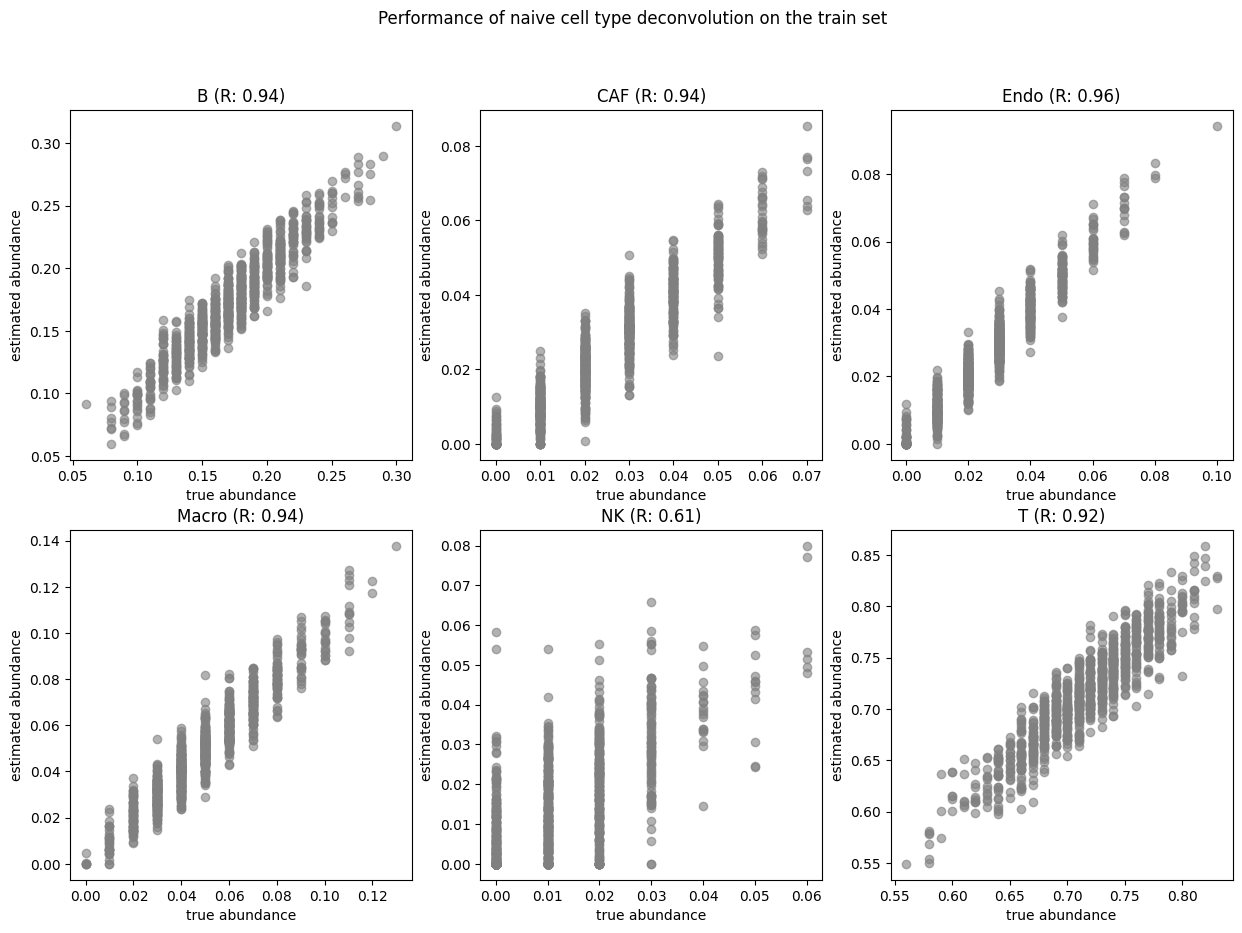

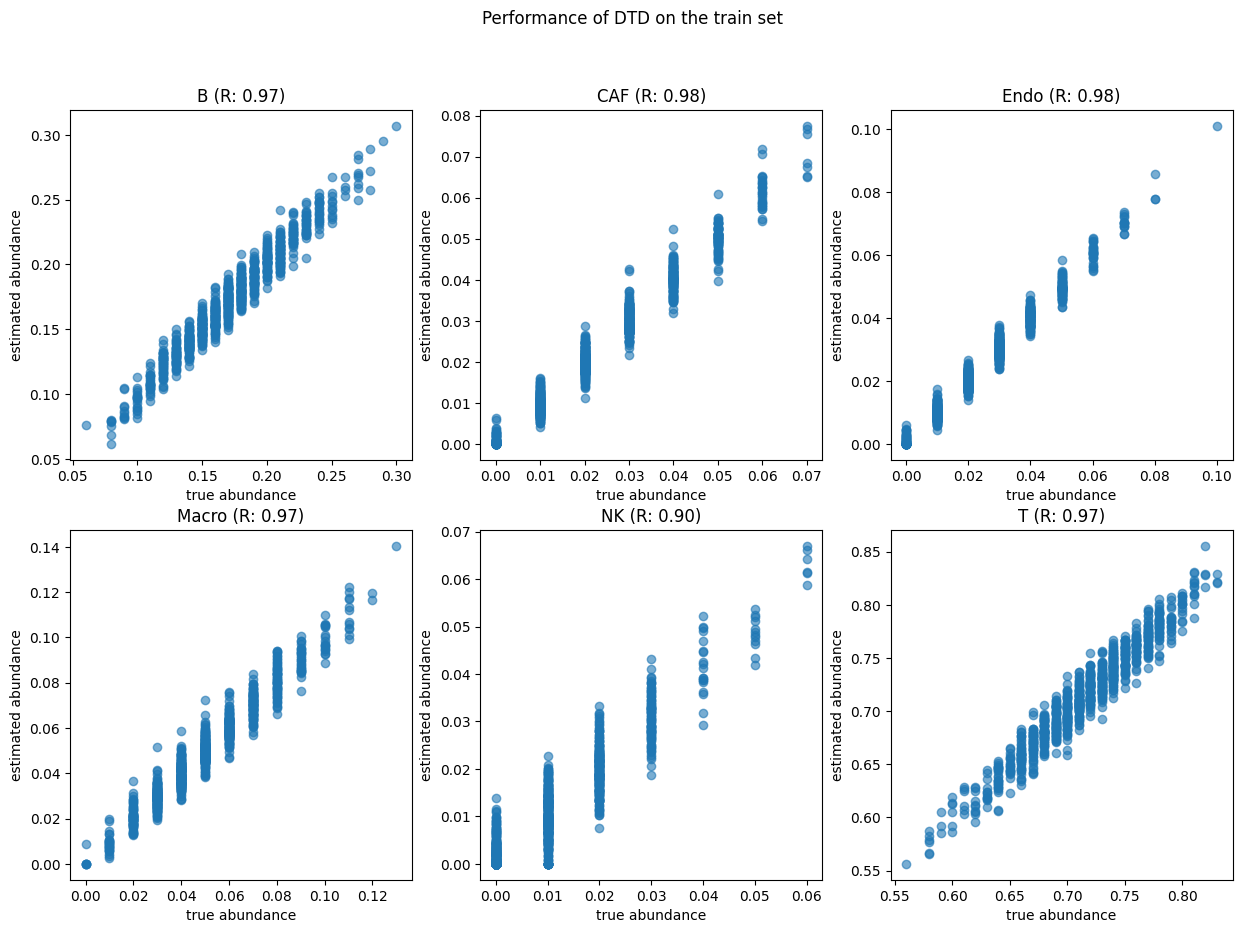

In [7]:
gamma_naive = pd.Series(np.ones((1000)))
gamma_naive.index = model0.gamma.index
C_est_train_naive = deconomix.utils.calculate_estimated_composition(X_ref, Y_mat, gamma_naive)  
corr_train_naive = deconomix.utils.plot_corr(C_mat, C_est_train_naive, title="Performance of naive cell type deconvolution on the train set")
corr_train = deconomix.utils.plot_corr(C_mat, C_est_train, title="Performance of DTD on the train set", color="C0")

All 6 celltypes show high correlation coefficients to our ground truth and have improved in comparison to the naive solution. Especially lower abundant cells like the NK cells were estimated significantly better (0.90 vs 0.61). This is expected on our training set. Let's try the same analysis for the test set, with our trained gamma and the same reference matrix, to see how well the model generalizes.

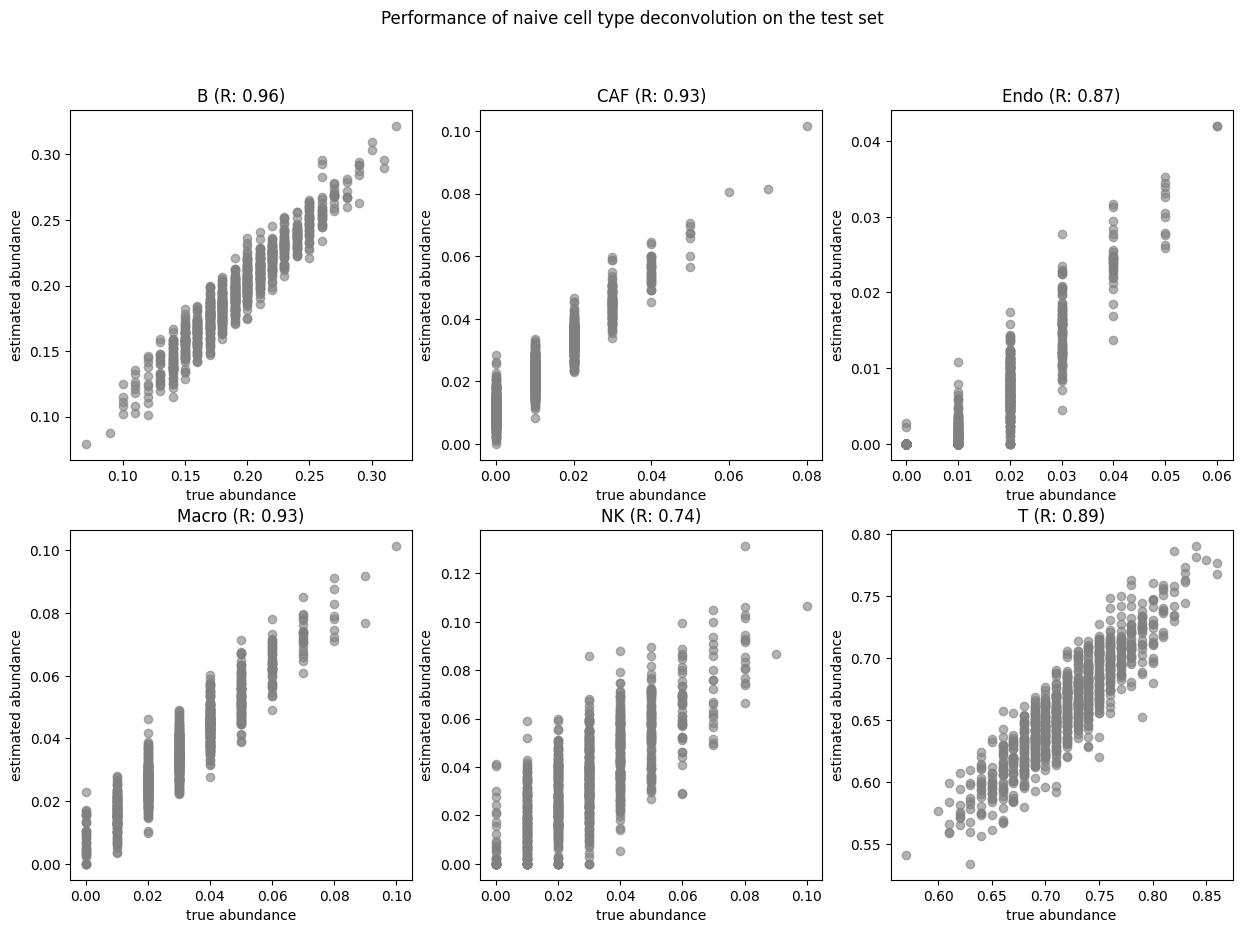

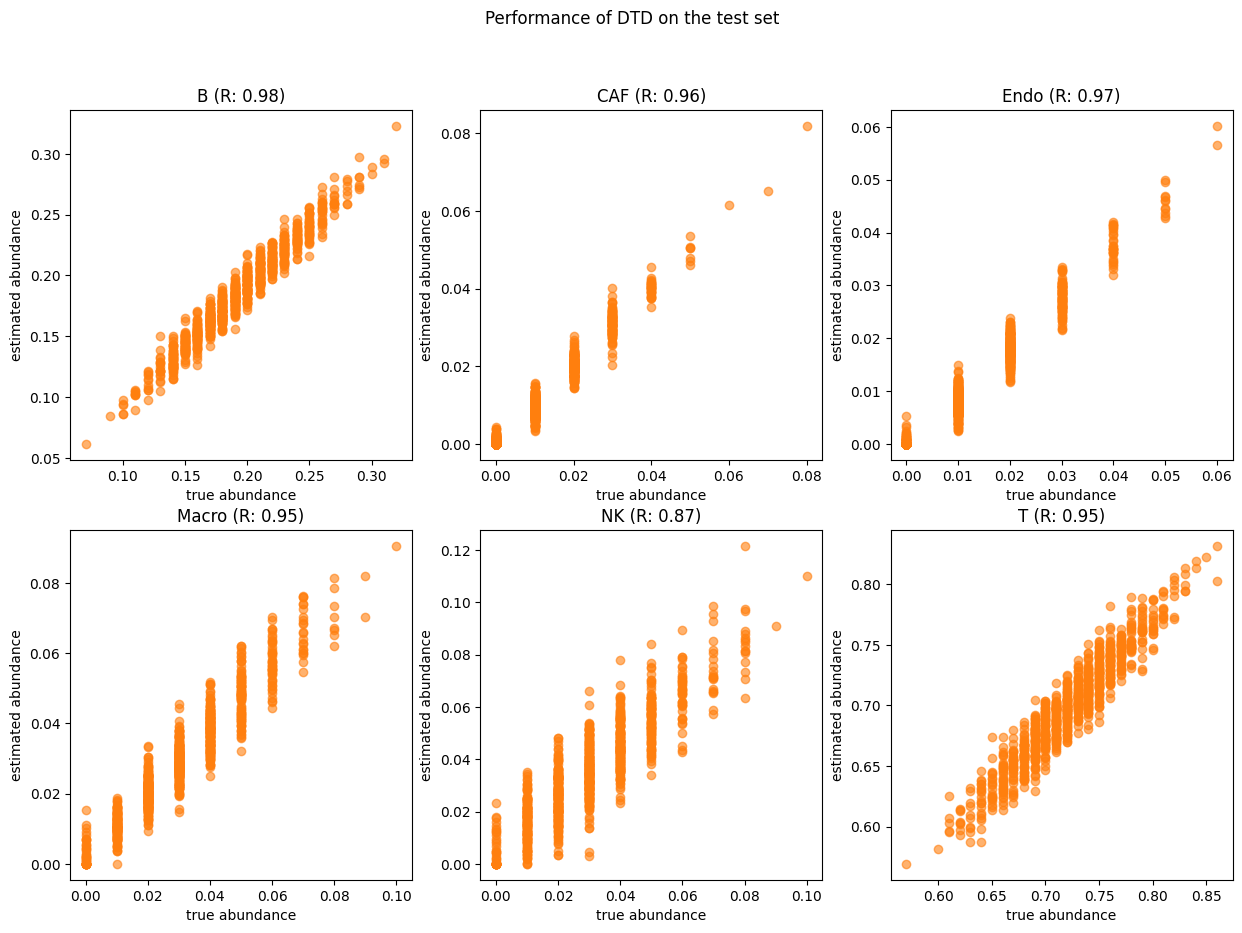

In [8]:
X_test , Y_test, C_test = deconomix.utils.simulate_data(test, n_mixtures = 1000, n_cells_in_mix = 100)
C_est_test = deconomix.utils.calculate_estimated_composition(X_ref, Y_test, model0.gamma)
C_est_test_naive = deconomix.utils.calculate_estimated_composition(X_ref, Y_test, gamma_naive)

corr_test_naive = deconomix.utils.plot_corr(C_test, C_est_test_naive, title="Performance of naive cell type deconvolution on the test set")
corr_test = deconomix.utils.plot_corr(C_test, C_est_test, title="Performance of DTD on the test set", color="C1")

The performance decreases a bit on the test set, which is expected. For the more common cell types in the dataset, good correlation values of over 0.8 can be achieved. Uncommon cell types, like NK cells are still estimated rather well with a correlation coefficient of 0.85.

## Estimating hidden background

Being familiar with the usual DTD routine, we want to demonstrate how to use the ADTD algorithm to estimate a hidden background. Therefore we construct a new problem with our example data, where we hide the B cells in our training set to simulate a hidden contribution of an unknown cell type to our bulks. Therefore we only train on artificial mixtures of all remaining, known cell types. This means, that the hidden cell type will also be missing from our reference matrix X.

In [9]:
X_ref, Y_mat, C_mat = deconomix.utils.simulate_data(train.drop("B", axis=1), n_mixtures = 1000, n_cells_in_mix = 100)

  0%|          | 0/500 [00:00<?, ?it/s]

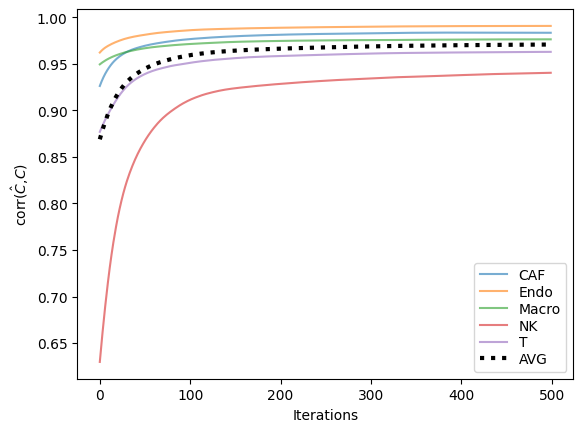

In [10]:
model1 = deconomix.methods.DTD(X_ref, Y_mat, C_mat)
model1.run(iterations = 500, plot = True)

After completing the DTD routine from the last section on our new data, we end up with a gene vector gamma, available as `model1.gamma`. However, just with DTD we cannot estimate possible hidden contributions to our bulk mixtures. For instance, in our test set, the hidden cells still contribute to the mixtures. We now want to use the ADTD algorithm to estimate those hidden contributions. The function `ADTD` takes our (incomplete) reference X, the test mixtures $Y$ and the gene weights from the DTD training we just conducted. The algorithm is quite computationally intensive. To speed up the process we assume that there is no gene regulation (`Delta_static = True`) between the reference profiles in X to the mixed in profiles in Y. In this scenario we know that this is true, because we artificially created them without applying any regulatory simulation.

**Hyperparameter choice**: For a good estimation of the hidden background contributions one needs to adjust $\lambda_1$, which calibrates between two solutions. For $\lambda_1 \rightarrow \infty$, the naive solution is retrieved, where the hidden cell proportions are given by the difference of all known cell type contributions to 100 percent. For $\lambda_1 \rightarrow 0$, $x$ and $C$ are estimated
simultaneously. With growing $\lambda_1$ values, the solutions are more strongly biased toward the naive solution. Note that the naive solution can be determined for each cellular mixture individually, while the latter solution requires a sufficient amount of bulk samples, however, providing the advantage that a consensus background is learned across a set of bulk specimens. Hyperparameters should be determined on a separate validation set. A demonstration how a gridsearch for ADTD can be conducted is available in `Example-Hyperparameter_Gridsearch.ipynb`.

**Normalization**: You don't have to normalize your reference profiles $X$ or your bulk samples $Y$ beforehand. Our ADTD model does normalize the data upon instantiation, where we fix the column-wise sums for all sample and reference profiles. It's just important to keep your values within a reasonable numerical range, to prevent floating point errors.

**Weight Offset**: Some genes are not relevant for the DTD task described before, they get assigned weights of 0 in the learning process. However, for the new objectives of ADTD those genes can be relevant.The ADTD class internally offsets the values in `gamma` to include all genes for maximum information.

In [11]:
model2 = deconomix.methods.ADTD(X_ref, Y_test, model1.gamma, C_static = False, Delta_static=True, lambda1=1e-6, max_iterations=500)
model2.run()

  0%|          | 0/500 [00:00<?, ?it/s]

After 297 Iterations, the algorithm met the convergence criterium and we obtain estimates for the contributions of the known cell types in `C_est`, an estimate of the contribution of the hidden background in `c_est` and an estimate for the corresponding hidden profile `x_est`, all available as attributes of the model.

In [12]:
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
model2.C_est

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Celltypes,,,,,,,,,,,,,,,,,,,,,
CAF,0.000,0.018,0.038,0.003,0.000,0.039,0.000,0.032,0.019,0.033,...,0.009,0.071,0.033,0.032,0.025,0.001,0.000,0.009,0.036,0.036
Endo,0.000,0.006,0.011,0.027,0.016,0.010,0.022,0.031,0.036,0.009,...,0.048,0.007,0.033,0.041,0.021,0.041,0.029,0.028,0.009,0.000
Macro,0.000,0.032,0.011,0.048,0.047,0.059,0.086,0.035,0.087,0.026,...,0.000,0.059,0.011,0.025,0.000,0.033,0.022,0.004,0.039,0.024
NK,0.000,0.027,0.023,0.000,0.052,0.033,0.071,0.023,0.009,0.016,...,0.000,0.007,0.045,0.007,0.000,0.000,0.024,0.006,0.032,0.033
T,0.724,0.589,0.636,0.545,0.549,0.471,0.497,0.597,0.556,0.561,...,0.550,0.532,0.595,0.618,0.453,0.694,0.407,0.669,0.528,0.566


In [13]:
model2.c_est

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
hidden,0.276,0.328,0.282,0.377,0.335,0.388,0.324,0.282,0.293,0.356,...,0.393,0.324,0.283,0.278,0.501,0.231,0.518,0.283,0.356,0.342


In [14]:
pd.set_option('display.float_format', lambda x: f'{x:.7f}')
model2.x_est

,0
Genes,
HLA-DRA,0.0058970
TYROBP,0.0005577
NKG7,0.0009558
IGFBP7,0.0000000
FCER1G,0.0005858
...,...
IMPDH2,0.0010343
SAR1A,0.0030033
RBMS3,0.0000000


To validate the results we calculate and visualize the correlations to the ground truth:

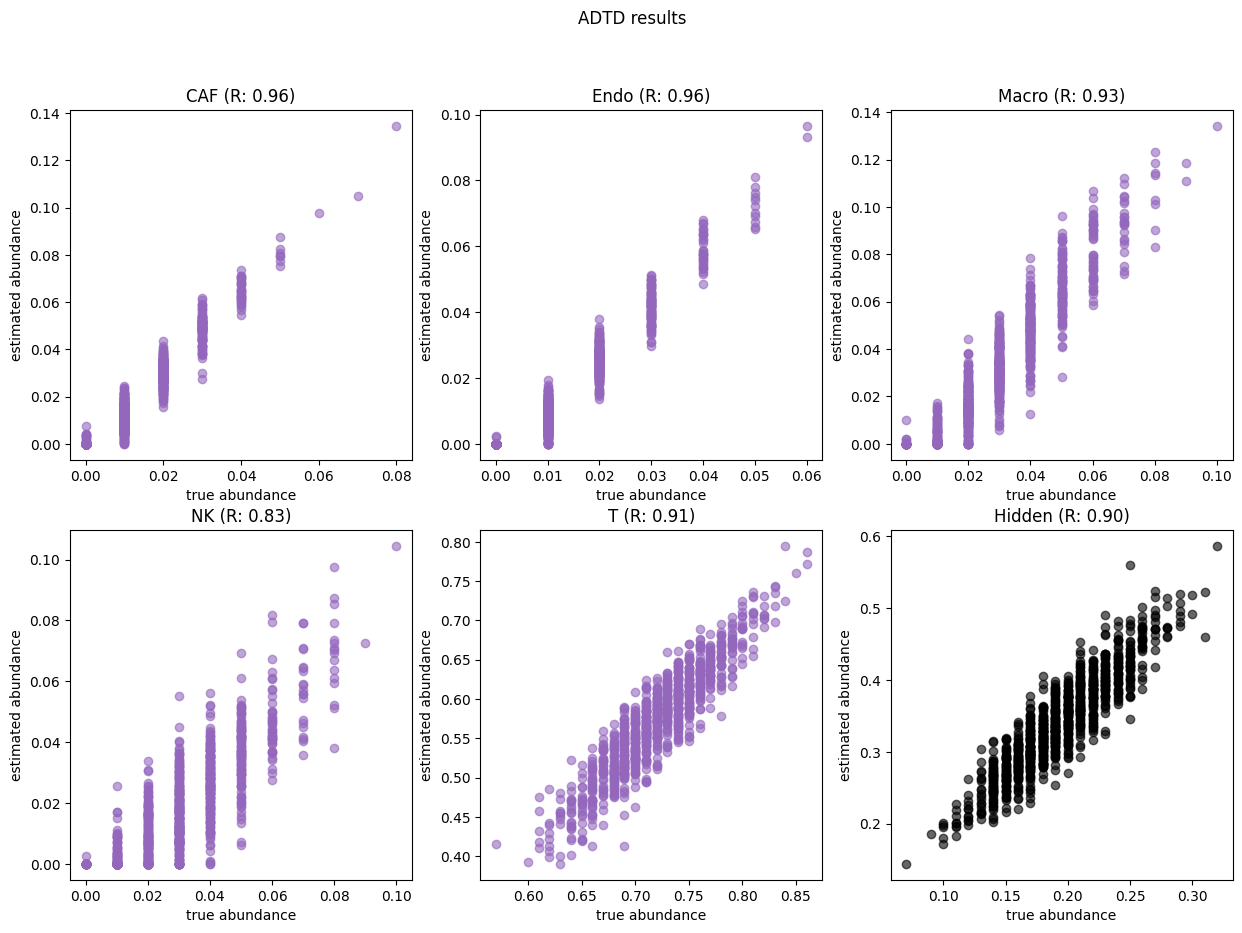

In [15]:
corr_hidden_no_regulation = deconomix.utils.plot_corr(C_test, model2.C_est, title="ADTD results", color="C4", hidden_ct="B", c_est=model2.c_est)

As visible in the plot above, we were able to predict the contributions `c_est` of the hidden cell type well, with a correlation coefficient of 0.9, while keeping a good performance for the known cell types, estimated in `C_est` Furthermore, the ADTD model estimated the hidden profile `x_est`:

In [16]:
print(spearmanr(X_test.loc[:,"B"], model2.x_est)[0])

0.8536865345144419


The estimated hidden consensus profile correlates with the ground truth with a correlation coefficient of 0.85.

## Estimating gene regulation

The reference data used for `X_ref` does not correspond 1:1 to the actual profiles in the bulk samples to be analyzed. Especially if the reference stems from healthy tissue, some genes might be expressed differently in a disease context for a cell type in a bulk sample. To account this problem, the ADTD algorithm is able to adapt the reference matrix X with element wise regulation factors in a matrix $\Delta$. We now want to create an example to showcase this feature.

First, we choose 7 expressed genes for the T-cells, which also have medium weights in gamma and upregulate them with a factor of 2:

In [17]:
regulated_genes = ['CXCR4', 'CD3D', 'FTH1', 'PTPRCAP', 'IL32', 'SRGN', 'PTPRC']
test_regulated = test.copy()
test_regulated.loc[regulated_genes, "T"] = 2 * test.loc[regulated_genes, "T"]

Then, we generate the corresponding bulk mixtures to these upregulated example profiles:

In [18]:
_ , Y_test_reg, C_test_reg = deconomix.utils.simulate_data(test_regulated, n_mixtures = 1000, n_cells_in_mix = 100)

Now we can plug in the reference profile from last section, where the B cells are still hidden, the gamma vector from before and our new bulks, where those genes are upregulated for the T-cells.

**Hyperparameter choice**: For a good estimation of $\Delta$ one needs to adjust $\lambda_2$. The limit $\lambda_2 \rightarrow \infty$ corresponds to ADTD without cellular adaptation. The smaller $\lambda_2$ is chosen, the more adaption of the reference profiles is allowed, leading to overfitting if chosen too small. To find proper hyperparameters one should split their data to do a grid search on a separate validation set, as shown in `Example-Hyperparameter_Gridsearch.ipynb`.

As a cost-efficient alternative we suggest to work with $\lambda_1 \to \infty$. Then you can determine a suitable $\lambda_2$ via the reconstruction error. The class `deconomix.methods.HPS` provides methods for estimating a suitable $\lambda_2$ value via k-fold cross validation. The hyperparameter can be chosen either by picking the minimum of the reconstruction error, which might be prone tho overfit. More conservative choices are the solution within one standard error of the minimum, or taking the point before the maximum gradient, starting from the biggest $\lambda_2$ value, e.g., if the slope given by the points $(a,b)$ yields the maximum value, then we return the bigger x-value in this case $a$ as optimal parameter. 

In [19]:
l2_model = deconomix.methods.HPS(X_ref, Y_test_reg, model1.gamma, lambda_min=1e-12, n_points=13)
l2_model.run()

  0%|          | 0/5 [00:00<?, ?it/s]

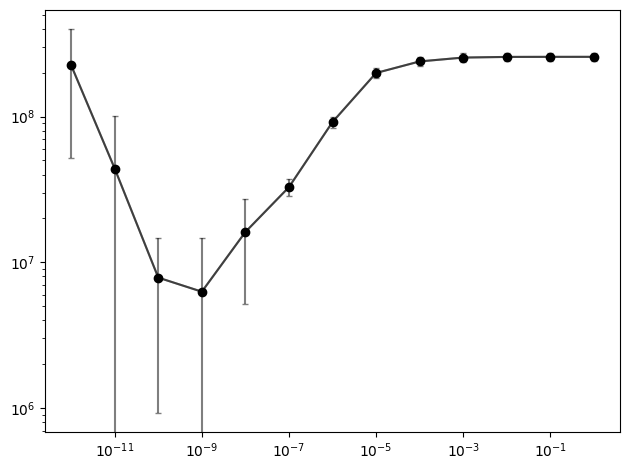

In [20]:
l2_model.get_plot(l2_model.Losses)

In [21]:
print(l2_model.lambda_min)
print(l2_model.lambda_1se)
print(l2_model.lambda_max_gradient)

1e-09
1e-09
0.0001


We proceed with the most conservative solution given by `lambda_max_gradient`. 

In [22]:
gamma_l2 =  1/ Y_test_reg.shape[1] * np.ones(Y_test_reg.shape[0]) / (Y_test_reg.mean(axis=1))**2
model3 = deconomix.methods.ADTD(X_ref, Y_test_reg, gamma_l2, Delta_static=False, C_static=True, lambda2=l2_model.lambda_max_gradient, max_iterations=3)
model3.run()

  0%|          | 0/3 [00:00<?, ?it/s]

Let's visualize the results by plotting `model3.Delta_est` for the regulated genes as a heatmap considering all cell types. The results for the other estimates are available as attributes `C_est`, `c_est` and `x_est` aswell.

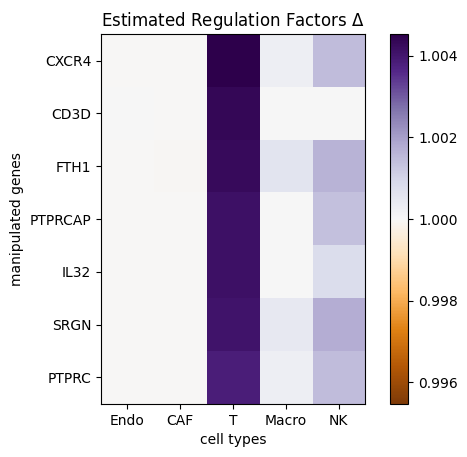

In [23]:
plt.figure()
plt.imshow(model3.Delta_est.loc[regulated_genes,["Endo","CAF","T","Macro","NK"]], cmap='PuOr', norm=CenteredNorm(1))
plt.yticks(ticks=range(0,len(regulated_genes)), labels=regulated_genes, rotation=0)
plt.xticks(ticks=range(0,5), labels=["Endo","CAF","T","Macro","NK"])
plt.xlabel("cell types")
plt.ylabel("manipulated genes")
plt.title("Estimated Regulation Factors $\\Delta$")
plt.colorbar()
plt.show()
#plt.savefig("plots_appnote/png/delta_heatmap.png")
#model3.Delta_est.to_pickle("Delta_est.pkl")

As seen in purple colors, the model was able to identify that the selected genes are up-regulated within the T-cells. The estimated factors for the other cell types are closer to 1, indicating low regulation. Note that the absolute value of the regulation factor does not correspond directly to the factor 2, we have used before. This is caused by the internal normalization taking place in the ADTD class. However, we can also identify slight outliers in the NK cells. This is likely due to the low abundance of NK cells in the mixtures. You should not trust those values blindly, they are just an indicator for the actual gene regulation in comparison to the reference. Note that the regulation estimation works well for genes with proper weights in the gamma vector and higher counts.

To confirm that our manipulated genes are in fact cell-type-specifically enriched in the entries of the Delta matrix, we prepare two ranked list of genes, one for T-cells and one for another celltype:

In [24]:
ranks_T = list(model3.Delta_est.sort_values(by='T', ascending=False).index)
ranks_Macro = list(model3.Delta_est.sort_values(by='Macro', ascending=False).index)

Now we can perform Fisher's exact test, to prove that our enrichment is statistically significant for T-cells in the top 5 percent of our featured genes:

In [25]:
_,_ = deconomix.utils.fishers_exact_test(ranks_T, regulated_genes, percentage=5)

Contingency Table:
                     In Regulated Genes  Not in Regulated Genes
In Top 50 Genes                       7                      43
Not in Top 50 Genes                   0                     950
Test Statistics:
Odds Ratio: inf, P-value: 5.141243935429293e-10



With a p-value well below a significance threshold of 0.05 and a high odds ratio, the test detected an enrichment of our manipulated genes in T-cells. Furthermore, we can show, that this is not the case for other cell types, like Macrophages:


In [26]:
_,_ = deconomix.utils.fishers_exact_test(ranks_Macro, regulated_genes, percentage=5)

Contingency Table:
                     In Regulated Genes  Not in Regulated Genes
In Top 50 Genes                       2                      48
Not in Top 50 Genes                   5                     945
Test Statistics:
Odds Ratio: 7.875, P-value: 0.04380743180760594



This shows that the model successfully identified the cell-type-specific regulation!

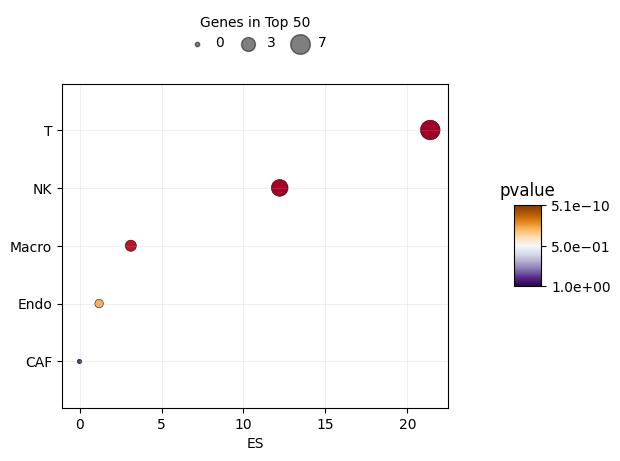

In [27]:
deconomix.utils.delta_enrichment(model3.Delta_est, regulated_genes)